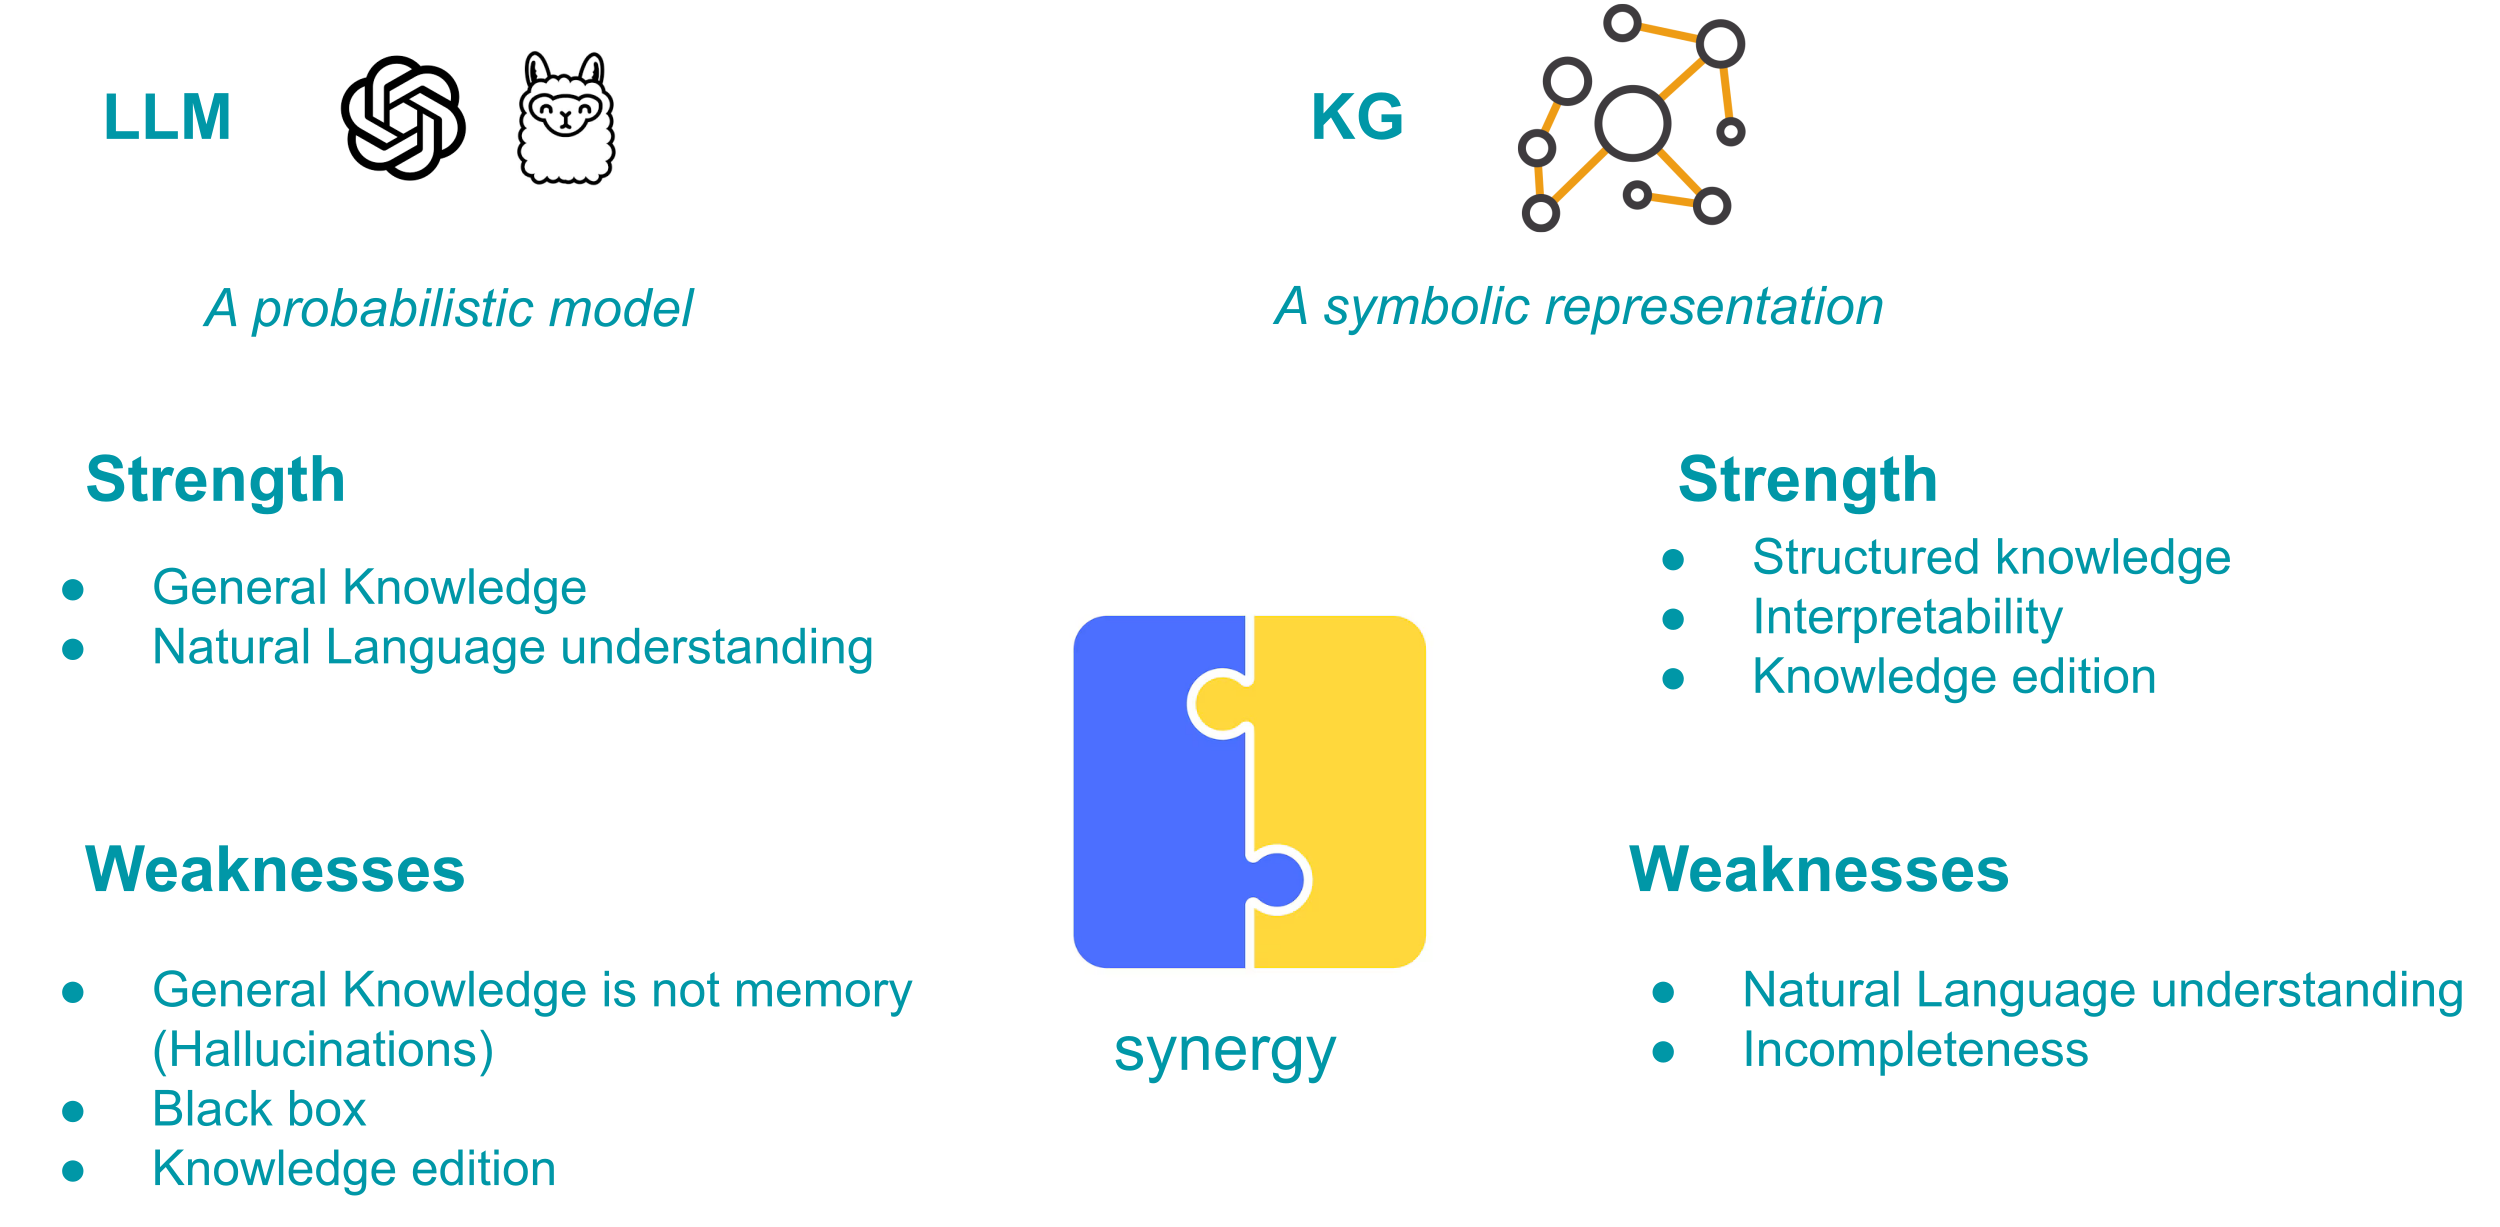

# KG Inference and RAG

In this notebook we are going to explore:

- Different types of queries on KG
- Comparison of RAG on documents and RAG on knowledge graphs
- Automatic generation of graph queries assisted by LLM
- Querying a large knowledge graph (Hetionet)
- Prediction of new links using translation approaches


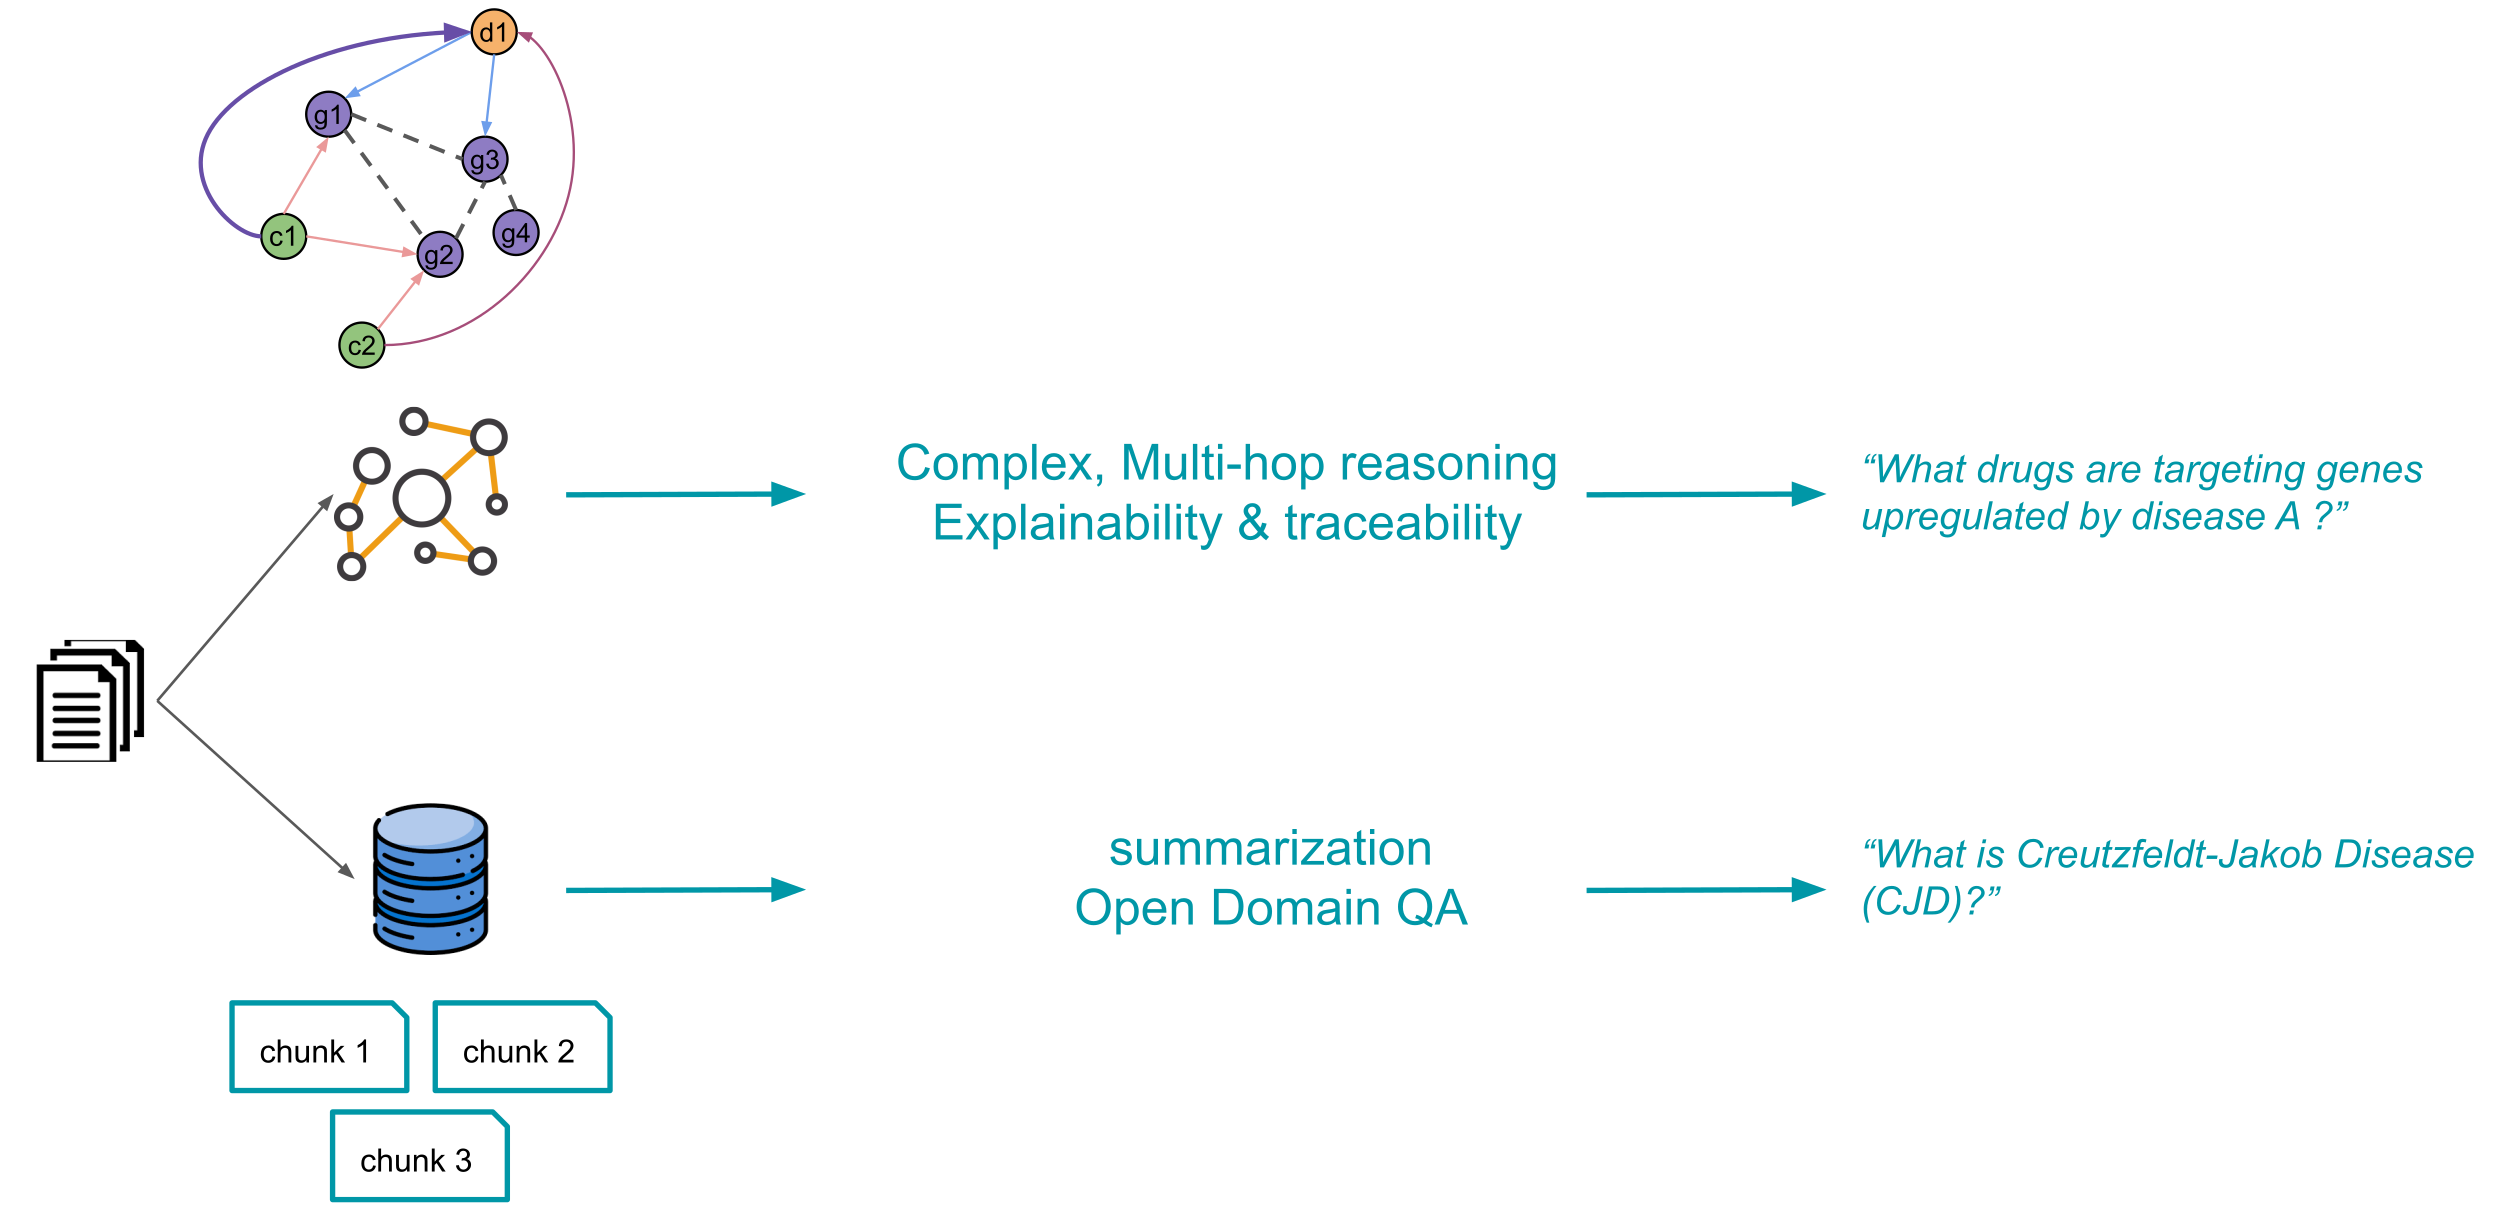

## Setup

In [ ]:
# Standard setup for participants
!pip install neo4j pandas dspy
# Run this for RAG
!pip install chromadb sentence-transformers openai python-dotenv

In [2]:
import json
import os
import dspy
import openai
import chromadb
import pandas as pd
from neo4j import GraphDatabase
from chromadb.config import Settings
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv
from typing import List, Dict, Any, Optional
from IPython.display import display, HTML, Markdown

## Connect to the Neo4J KG

In [3]:
# =============================================================================
# 1. CONNECTION SETUP
# =============================================================================
# Replace with your Neo4j Aura credentials
NEO4J_URI = "neo4j+s://1c51a1ef.databases.neo4j.io"  # Note: neo4j+s for Aura
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "LwJT5kjrM1dX5ntarTB0XRY8LCrfBqoOA0_IRjRLGOg"

In [4]:
class Neo4jLoader:
  def __init__(self, uri, user, password):
    self.driver = GraphDatabase.driver(uri, auth=(user, password))
    self.test_connection()

  def test_connection(self):
    """
    Just a simple test for the connection
    """
    with self.driver.session() as session:
        result = session.run("RETURN 'Connection successful!' as message")
        return result.single()["message"]

  def close(self):
    """
    Close the driver connection
    """
    self.driver.close()

  def execute_query(self, cypher_query, parameters=None):
    """
    Execute a Cypher query and return all results

    Args:
        cypher_query (str): The Cypher query to execute
        parameters (dict, optional): Parameters for the query

    Returns:
        list: List of records from the query result
    """
    with self.driver.session() as session:
        result = session.run(cypher_query, parameters or {})
        result_df = pd.DataFrame((x.values() for x in result), columns=result.keys())
    return result_df




In [5]:
loader = Neo4jLoader(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)

# 1. Querying the KG

LLM do not have a memory of facts, particularly for long tail knowledge. For complex question answering and inference, LLM need to be grounded with relevant information that can be retrieved from a corpus of documents, or, a Knowledge Graph, hence **R**etrieval **A**ugmented **G**eneration (or **RAG**).
ions.

In the previous notebook we have extracted some PubMed reference from the BioASQ dataset associated with some questions and built a Knowledge graph from it using PubTator API.

But when retrieving information, when should we actually use the KG or the raw documents ?

In the first part on this notebook we are going to explore this question by comparing 2 RAG strategies:

- KG-RAG: Retrieving **structured** data from the KG and answering question

- Vanilla-RAG: Retrieving **unstructured** documents for a corpus text and answering questions.




In this first part we are going to query the KG we built in the previous notebook from PubTator on a est of 5 illustrative questions.

**Questions 1 and 2** are factual questions that require "listing" entities relevant to a question, a task at which KG excels by their structured nature.

**Question 3** is a typical example of a multi-hop query: `(Drugs)-[treat]->(Disease)-[associated]->(Gene)`

In **Question 4** we are going to leverage the power of Graph queries to extract some biologically meaningful subgraphs.



**Question 5** leverage a simple network strategy to infer missing links.

### Question 1: Dracorhodin perchlorate was tested for treatment of which cancers?

**Question id:** `56bcdf1ad36b5da378000009`

**Question type**: LIST

**Ideal answer:** *"Dracorhodin perchlorate induce apoptosis in prostate cancer, gastric tumor, melanoma and premyelocytic leukemia."*

**Documents:**
- [ref 1](http://www.ncbi.nlm.nih.gov/pubmed/23869191)
- [ref 2](http://www.ncbi.nlm.nih.gov/pubmed/15215653)
- [ref 3](http://www.ncbi.nlm.nih.gov/pubmed/16864444)
- [ref 4](http://www.ncbi.nlm.nih.gov/pubmed/22711363)
- [ref 5](http://www.ncbi.nlm.nih.gov/pubmed/15684474)
- [ref 6](http://www.ncbi.nlm.nih.gov/pubmed/21505988)

In [ ]:
a_simple_query = """
MATCH (c:Chemical)-[r:treat]->(d:Disease)
WHERE 'dracorhodin perchlorate' IN c.alt_names
RETURN d.name, r.pmids
"""
loader.execute_query(a_simple_query)

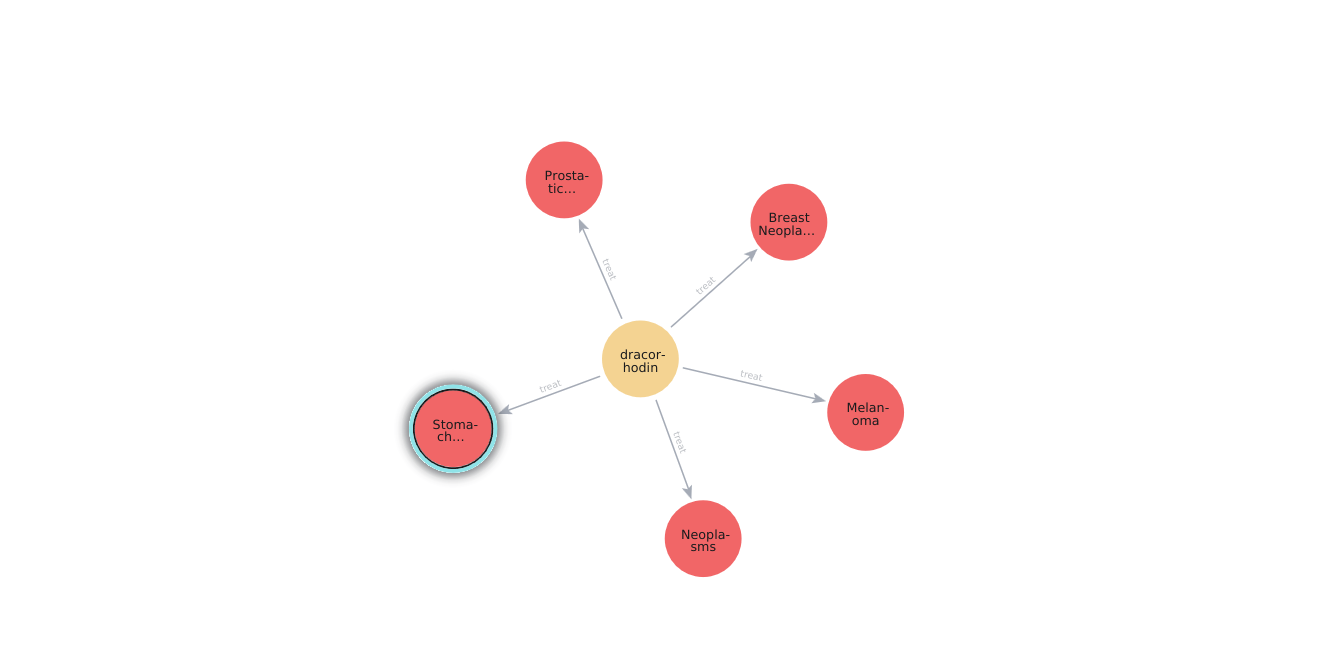

### Question 2: Which genes have been associated with Cerebral Cavernous Malformation ?


**Question id:** `571f2b5bbb137a4b0c000010`

**Question type**: LIST

**Ideal answer:** *"Loss-of-function mutations in genes encoding CCM1 (also known as KRIT1), CCM2 (also known as OSM and malcavernin) or CCM3 (also known as PDCD10) cause cerebral cavernous malformations (CCMs)."*

**Documents:**
- [ref 1](http://www.ncbi.nlm.nih.gov/pubmed/25122144)
- [ref 2](http://www.ncbi.nlm.nih.gov/pubmed/24287896)
- [ref 3](http://www.ncbi.nlm.nih.gov/pubmed/20592472)
- [ref 4](http://www.ncbi.nlm.nih.gov/pubmed/24466005)
- [ref 5](http://www.ncbi.nlm.nih.gov/pubmed/24481819)
- [ref 6](http://www.ncbi.nlm.nih.gov/pubmed/12172908)
... many more !

In [ ]:
a_simple_query = """
MATCH (g:Gene)-[r]-(d:Disease)
WHERE 'Cerebral cavernous malformation' IN d.alt_names
RETURN g.name, type(r), r.pmids
"""
loader.execute_query(a_simple_query)

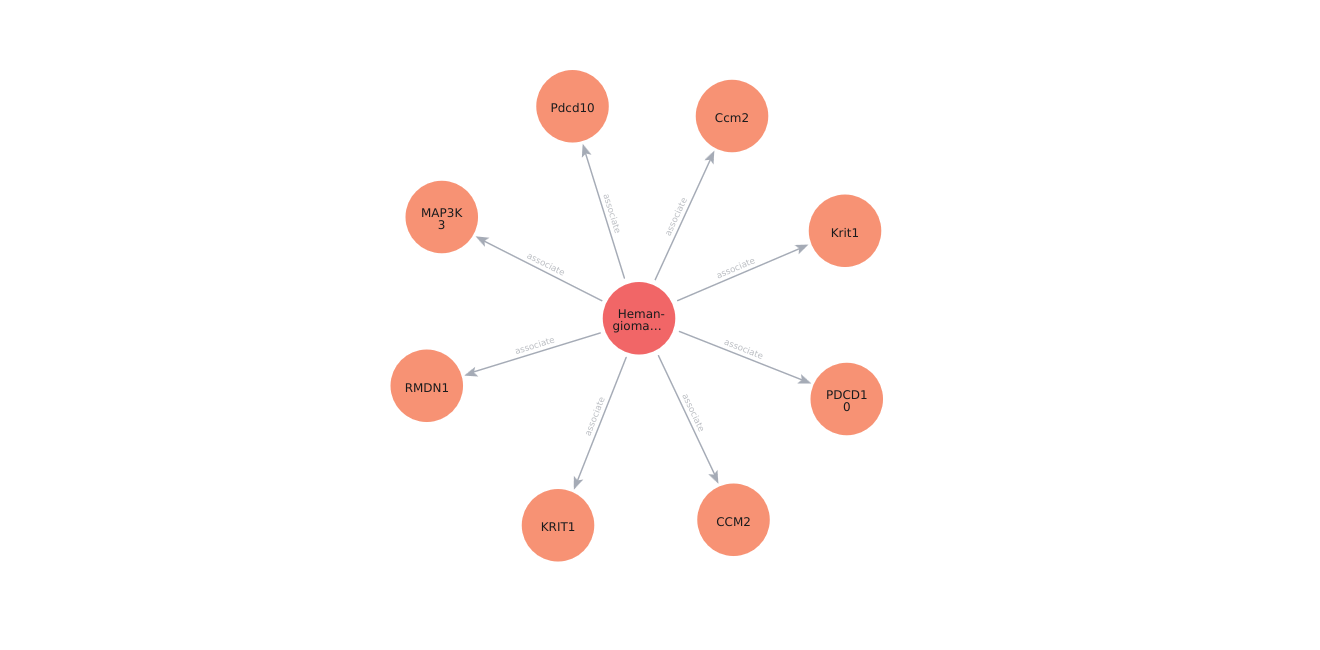

What about MEKK3 for instance ? Actually could be a false positive ! See [ref](https://www.nature.com/articles/nature17178)

Why do we have 2 CCM2 ? One is the Human Gene, one is from the mouse.

Infering on the Graph is not only about **list** questions, but we can also look for more complex patterns.

### Question 3: What drugs are treating diseases associated with IL17A ?

Here is a simple mutli-hop traversal of the graph !

In [ ]:
a_query = """
MATCH (g:Gene {name: "IL17A"})<-[r1:associate]-(d:Disease)<-[r2:treat]-(c:Chemical)
RETURN DISTINCT c.name AS chemical, d.name AS disease, r1.pmids AS Assoc_Ref, r2.pmids AS Treatment_Ref
"""
loader.execute_query(a_query)

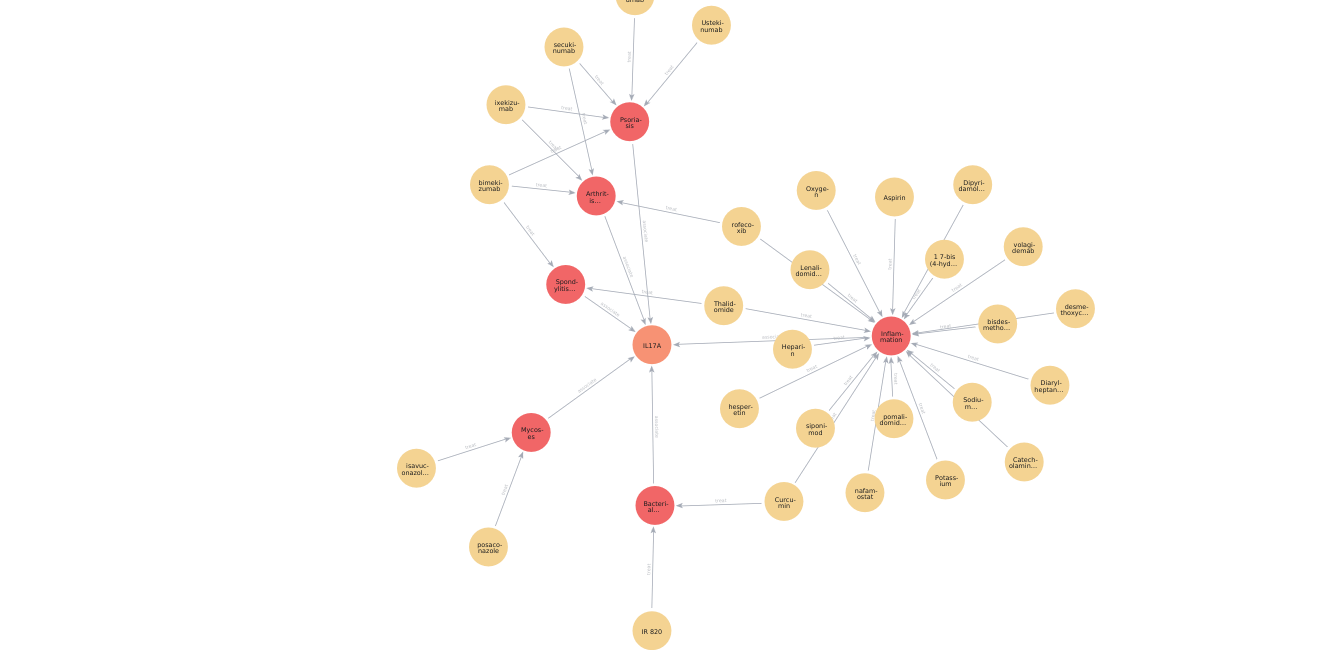

### Question 4: Finding toxicity related chemicals

Here we try to find a triangle between diseases, chemicals and genes.
For instance when a chemical is known to 'cause' or participate in a disease, for which we know some associated genes, but, where the chemical is also knwon to affect those genes. In this way this pattern can partially ellucidate some potential mecanisms.


In [ ]:
a_query = """
MATCH (g:Gene)<-[r1:associate]-(d:Disease)<-[r2:cause]-(c:Chemical)
MATCH (c)-[r3:negative_correlate]-(g)
RETURN g.name, d.name, c.name, r1.pmids, r2.pmids, r3.pmids
"""
loader.execute_query(a_query)

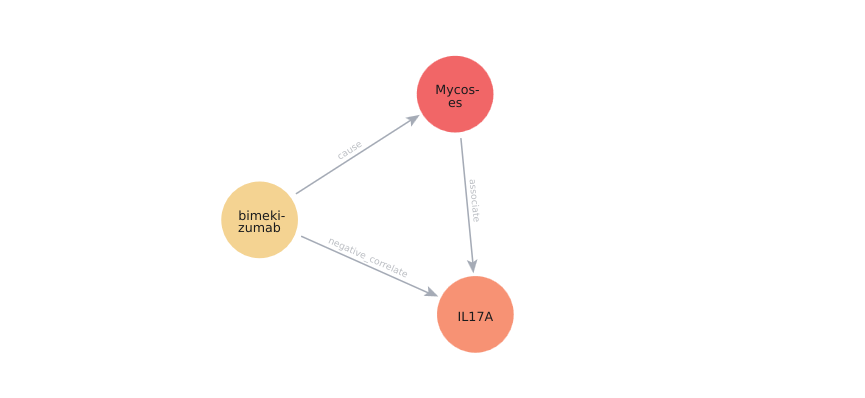

Check references:

- `(IL17A)-[associate]->(Mycoses)`: [*Candida infections in patients with psoriasis and psoriatic arthritis treated with interleukin-17 inhibitors and their practical management.*](https://pubmed.ncbi.nlm.nih.gov/33026212)

- `(bimekizumab)-[neg_correlation]->(IL17A)`: [*Emerging treatment options for the treatment of moderate to severe plaque psoriasis and psoriatic arthritis: evaluating bimekizumab and its therapeutic potential*](https://pubmed.ncbi.nlm.nih.gov/31214486)

- `(bimekizumab)-[cause]->(Mycoses)`: [*Bimekizumab: a dual IL-17A and IL-17F inhibitor for the treatment of psoriasis and psoriatic arthritis*](https://pubmed.ncbi.nlm.nih.gov/34384327)

### Question 5: Hypothesis discovery

What about if we ask the graph: find all Genes (g1) for which other associated genes (g2) are associated to a disease (d), but (g1) is not associated to (d).



Actually we know that our graph is missing a lot of relations. Indeed, we only built it from just > 1500 pubmed abtracts. However this can be use to check the inference over some links. Here, without using any complex embeddings methods, but the *Friend of a friend hypothesis* hypothesis.


*The friend-of-a-friend (FoF) hypothesis comes from social network theory. It states that if two people share a mutual friend, they are more likely to become friends themselves compared to two people chosen at random.* Here we can apply this reasoning to Genes and Diseases.

In [ ]:
a_query = """
MATCH (g1:Gene)-[:associate]-(g2:Gene)-[:associate]-(d:Disease)
WHERE NOT (g1)-[:associate]->(d)
WITH g1, d, count(g2) AS shared_intermediaries
ORDER BY shared_intermediaries DESC
RETURN g1.name AS gene_name, d.name AS disease_name, shared_intermediaries
"""
loader.execute_query(a_query)


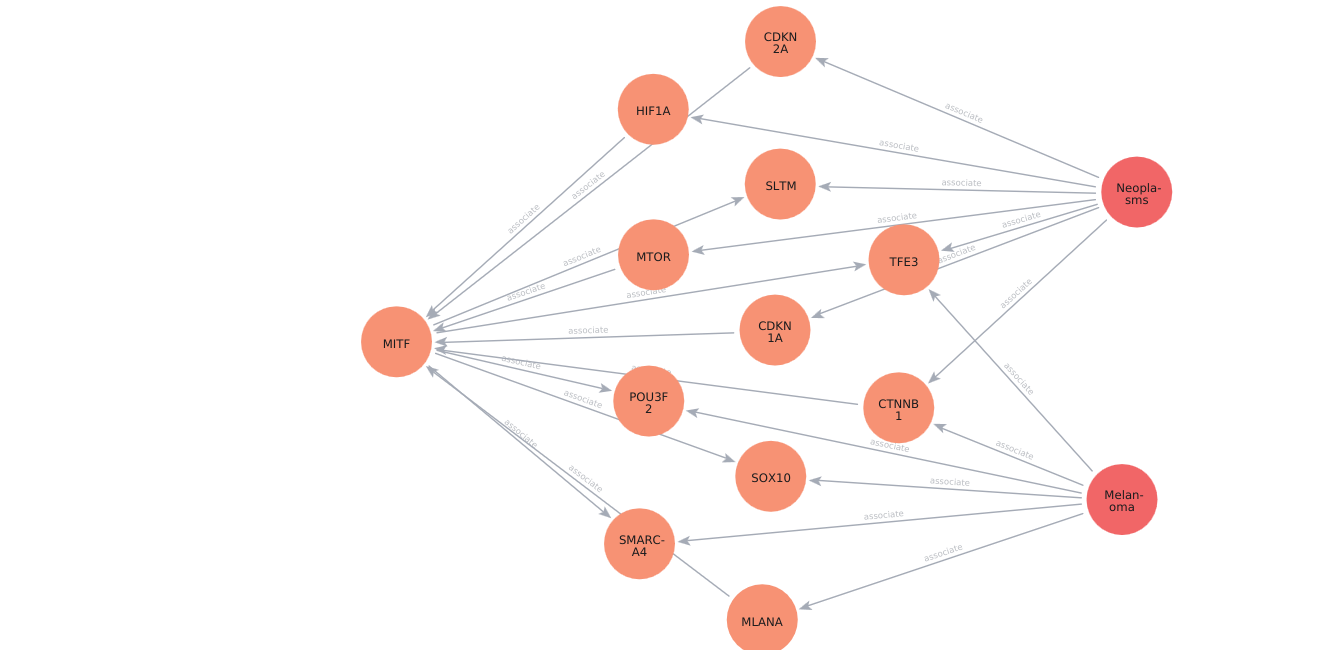

**Does my question is relevant for a KG inference ?**

- Am I expecting a list of entities ?
- Can I "draw" the query, or, can I represent it as a graph pattern ?

if not, probably vanilla RAG !

# 2. RAG

Now, let's compare to what we can obtain using a vanilla-RAG system, meaning only requesting the raw documents.

For the technical details, we are going to use [chromadb](https://www.trychroma.com/) as the vector database (very easy for prototyping) and **BAAI/bge-large-en-v1.5** a classic and generalist vector encoder.

We are going to re-ask questions 1, 2 and 3 over the raw documents database.


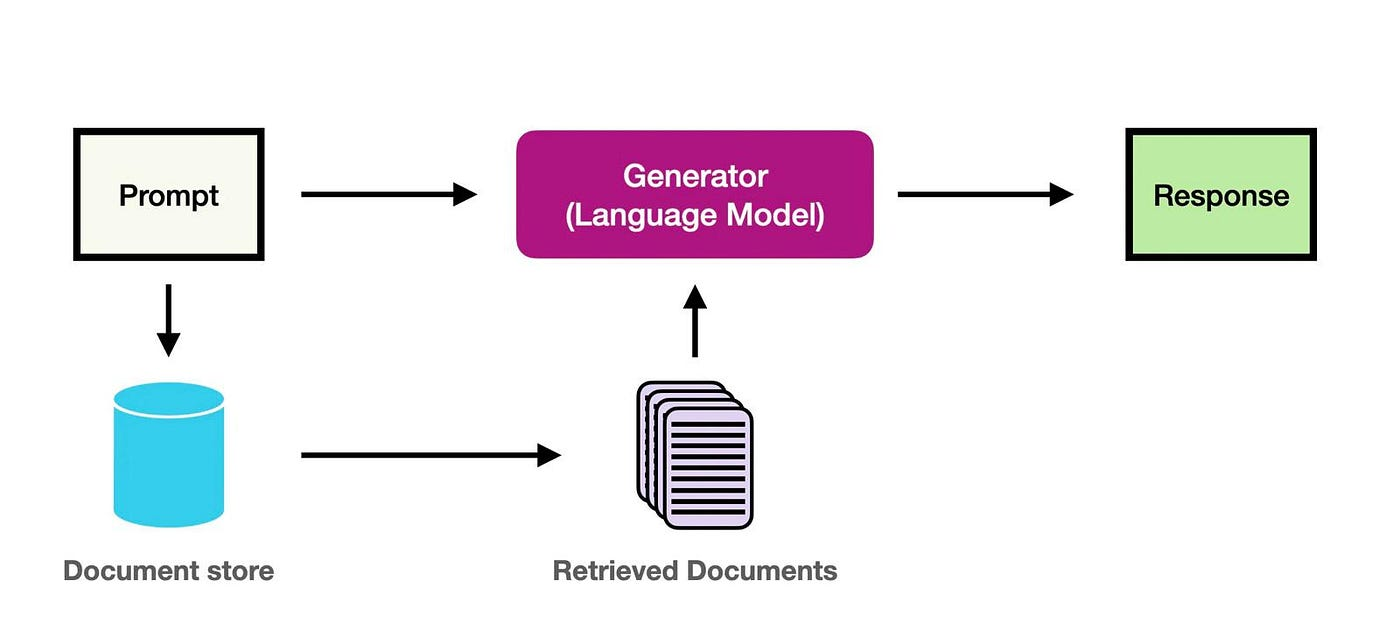

## Settings

In [18]:
# Load environment variables (for API keys)
load_dotenv()

# Configuration class for different LLM backends
class LLMConfig:
    @staticmethod
    def setup_openai(api_key: str, model: str = "gpt-4.1-mini", max_tokens=2048):
        """Setup OpenAI API"""
        import openai
        openai.api_key = api_key
        lm = dspy.LM(model, max_tokens=max_tokens)
        dspy.configure(lm=lm, adapter=dspy.JSONAdapter())
        dspy.settings.lm.kwargs["temperature"] = 0.0
        return lm

    @staticmethod
    def setup_ollama(api_base: str = "http://127.0.0.1:11434", model: str = "llama3.1:8b", max_tokens=2048):
        """Setup Ollama local model"""
        lm = dspy.LM(model, api_base=api_base, max_tokens=max_tokens)
        dspy.configure(lm=lm, adapter=dspy.JSONAdapter())
        dspy.settings.lm.kwargs["temperature"] = 0.0
        return lm

class RAGConfig:
    """Configuration class for our RAG system"""

    def __init__(self,
                 embedding_model: str = "BAAI/bge-large-en-v1.5",
                 collection_name: str = "pubmed_abstracts",
                 llm_type: str = "openai",
                 llm_model = "gpt-4.1-nano",
                 base_url="http://127.0.0.1:11434",
                 api_key: Optional[str] = None,
                 **kwargs):

        self.embedding_model = embedding_model
        self.collection_name = collection_name
        self.llm_type = llm_type

        if llm_type == "openai":
            api_key = kwargs.get("api_key", os.getenv("OPENAI_API_KEY"))
            self.lm = LLMConfig.setup_openai(api_key, llm_model)
        elif llm_type == "ollama":
            print(f"model: {llm_model} / base_url: {base_url}")
            self.lm = LLMConfig.setup_ollama(base_url, llm_model)

class DocumentProcessor:
    """Handles document processing and embedding generation"""

    def __init__(self, embedding_model_name: str):
        self.embedding_model = SentenceTransformer(embedding_model_name)
        print(f"Embedding model loaded: {embedding_model_name}")

    def process_documents(self, json_documents: List[Dict]) -> tuple:
        """
        Process JSON documents and prepare them for vector storage

        Args:
            json_documents: List of document dictionaries with 'pmid' and 'text'

        Returns:
            Tuple of (texts, embeddings, metadatas, ids)
        """
        texts = []
        metadatas = []
        ids = []

        print(f"Processing {len(json_documents)} documents...")

        for doc in json_documents:
            pmid = doc.get('pmid', 'unknown')
            text = doc.get('text', '')

            if text.strip():  # Only process non-empty texts
                texts.append(text)
                metadatas.append({
                    'pmid': pmid,
                    'length': len(text)
                })
                ids.append(f"doc_{pmid}")

        print(f"Generating embeddings for {len(texts)} documents...")
        embeddings = self.embedding_model.encode(texts, show_progress_bar=True)

        return texts, embeddings.tolist(), metadatas, ids

class VectorDatabase:
    """Manages ChromaDB operations"""

    def __init__(self, collection_name: str):
        self.collection_name = collection_name

        # Initialize ChromaDB client
        self.client = chromadb.PersistentClient(
            path="./chroma_db"
        )

        # Create or get collection
        try:
            self.collection = self.client.create_collection(
                name=collection_name,
                metadata={"hnsw:space": "cosine"}
            )
            print(f"Created new collection: {collection_name}")
        except:
            self.collection = self.client.get_collection(name=collection_name)
            print(f"Using existing collection: {collection_name}")

    def add_documents(self, texts: List[str], embeddings: List[List[float]],
                     metadatas: List[Dict], ids: List[str]):
        """Add documents to the vector database"""

        print(f"Adding {len(texts)} documents to ChromaDB...")

        self.collection.add(
            documents=texts,
            embeddings=embeddings,
            metadatas=metadatas,
            ids=ids
        )

        print(f"Successfully added {len(texts)} documents to the database")

    def search(self, query_embedding: List[float], top_k: int = 5) -> Dict:
        """Search for similar documents"""

        results = self.collection.query(
            query_embeddings=[query_embedding],
            n_results=top_k,
            include=["documents", "metadatas", "distances"]
        )

        return results

class RetrievalSignature(dspy.Signature):
    """Signature for the retrieval component"""
    query = dspy.InputField(desc="User's question or search query")
    context = dspy.InputField(desc="Retrieved relevant document chunks (can be empty)")
    answer = dspy.OutputField(desc="Comprehensive answer based on the context")

class RAGModule(dspy.Module):
    """Main RAG module using DSPy"""

    def __init__(self, vector_db: VectorDatabase, embedding_model: SentenceTransformer):
        super().__init__()
        self.vector_db = vector_db
        self.embedding_model = embedding_model

        # DSPy components
        self.generate_answer = dspy.ChainOfThought(RetrievalSignature)

    def retrieve(self, query: str, top_k: int = 5) -> tuple:
        """Retrieve relevant documents for a query"""

        # Generate query embedding
        query_embedding = self.embedding_model.encode([query])[0].tolist()

        # Search vector database
        results = self.vector_db.search(query_embedding, top_k)

        # Format retrieved documents
        retrieved_docs = []
        for i in range(len(results['documents'][0])):
            doc_info = {
                'content': results['documents'][0][i],
                'pmid': results['metadatas'][0][i]['pmid'],
                'distance': results['distances'][0][i],
                'relevance_score': 1 - results['distances'][0][i]  # Convert distance to relevance
            }
            retrieved_docs.append(doc_info)

        return retrieved_docs, results

    def forward(self, query: str, top_k: int = 5):
        """Main forward pass of the RAG system"""

        # Step 1: Retrieve relevant documents
        if top_k > 0:
            retrieved_docs, raw_results = self.retrieve(query, top_k)

            # Step 2: Prepare context for LLM
            context_parts = []
            for i, doc in enumerate(retrieved_docs):
                context_parts.append(f"Document {i+1} (PMID: {doc['pmid']}):\n{doc['content']}")

            context = "\n\n".join(context_parts)
        else:
            print("No context will be retrieved !")
            context = ""
            retrieved_docs = []

        # Step 3: Generate answer using DSPy
        prediction = self.generate_answer(query=query, context=context)

        return dspy.Prediction(
            answer=prediction.answer,
            retrieved_docs=retrieved_docs,
            context=context,
            query=query
        )



class PubMedRAG:
    """Complete RAG system for PubMed"""

    def __init__(self, config: RAGConfig):
        self.config = config

        # Initialize components
        self.doc_processor = DocumentProcessor(config.embedding_model)
        self.vector_db = VectorDatabase(config.collection_name)
        self.rag_module = RAGModule(self.vector_db, self.doc_processor.embedding_model)

        print("RAG System initialized successfully!")

    def load_documents(self, json_file_path: str = None, json_data: List[Dict] = None):
        """Load documents from JSON file or data"""

        if json_file_path:
            print(f"Loading documents from {json_file_path}...")
            with open(json_file_path, 'r', encoding='utf-8') as f:
                documents = json.load(f)
        elif json_data:
            print("Loading documents from provided data...")
            documents = json_data
        else:
            raise ValueError("Either json_file_path or json_data must be provided")

        # Process documents
        texts, embeddings, metadatas, ids = self.doc_processor.process_documents(documents)

        # Add to vector database
        self.vector_db.add_documents(texts, embeddings, metadatas, ids)

        return len(documents)

    def search(self, query: str, top_k: int = 5) -> Dict[str, Any]:
        """Search the knowledge base and generate an answer"""

        print(f"Searching for: '{query}' (top_k={top_k})")

        # Get prediction from RAG module
        prediction = self.rag_module(query, top_k)

        # Format response
        response = {
            'query': query,
            'answer': prediction.answer,
            'retrieved_documents': [
                {
                    'pmid': doc['pmid'],
                    'content': doc['content'],
                    'full_content': doc['content'],
                    'relevance_score': round(doc['relevance_score'], 4)
                }
                for doc in prediction.retrieved_docs
            ],
            'top_k': top_k
        }

        # display the answer nicely
        markdown_content = f"**Question:** {response['query']}\n\n\n**Answer**:{response['answer']}\n**Retrieved Documents**:\n"

        for i, doc in enumerate(response['retrieved_documents'], 1):
            markdown_content += f"""
        Document {i} - PMID: {doc['pmid']} (Relevance: {doc['relevance_score']:.3f})
        {doc['content']}

        """
        display(Markdown(markdown_content))
        return response




## Indexing

In [ ]:
config = RAGConfig(llm_type="openai",
        api_key=os.getenv("OPENAI_API_KEY"),
        embedding_model="BAAI/bge-large-en-v1.5",
        llm_model="gpt-4.1-nano"
    )
rag_system = PubMedRAG(config)
num_docs = rag_system.load_documents(json_file_path="/content/documents_texts_with_pmid.json")

## QA

### Factual QA


In this case, is relatively easy for a vanilla RAG to found the links, because by design our questions are sourced from the PubMed documents and there is not much entities to list.

But for Q: "What drugs are treating diseases associated to mutations of IL17A ?" is different !

In [ ]:
response = rag_system.search("Dracorhodin perchlorate was tested for treatment of which cancers ?", top_k=3)

In [ ]:
response = rag_system.search("Which genes have been associated with Cerebral Cavernous Malformation ?", top_k=3)

In [ ]:
response = rag_system.search("What drugs are treating diseases associated with IL17A ?", top_k=3)

Actually, how can I even ask question 4 and 5 ?

In [ ]:
response = rag_system.search("What chemicals is known to 'cause' or participate in a disease, for which we know some associated genes, but, where the chemical is also knwon to affect those genes ?", top_k=5)

In [ ]:
response = rag_system.search("Find all Genes (g1) for which other associated genes (g2) are associated to a disease (d), but (g1) is not associated to (d). ?")

### A more global QA:

In [ ]:
response = rag_system.search("What is the mechanism of action of drisapersen ?")

Actually here, how could I even ask this question to my graph ?

**Then,**

- If questions are expecting a deterministic answer: KG

- If questions are open / summarisation: raw text

**The right tool for the righ job !** 💪

# 3. KAG, or, who likes to write SPARQL / Cypher queries ?

In this new section of the notebook we are going to explore some practical examples of generating Cypher queries from natural language to request our KG.
We are also going to extend this example to a larger Knowledge Graph: hetionet.


## Setup

In [26]:
import dspy

class QuestionToCypher(dspy.Signature):
    """Convert a natural language question about biomedical entities into a Cypher query for Neo4j knowledge graph.
    You will be given:
    - a description of the Knowledge Graph
    - a set of relevant cypher query templates

    Generate syntactically correct Cypher queries that match the question's intent.
    Use appropriate node labels, relationship types, and property filters.
    """

    question = dspy.InputField(desc="Natural language question about biomedical entities and relationships")
    kg_description = dspy.InputField(desc="A description of the Knowledge Graph")
    templates = dspy.InputField(desc="Predefined query templates")
    cypher_query = dspy.OutputField(desc="Cypher query to answer the question")

class GenerateAnswer(dspy.Signature):
    """Generate a comprehensive answer to a biomedical question using query results from a knowledge graph.

    Synthesize the provided query results into a clear, informative response that directly addresses
    the original question. Include relevant details from the results and explain the biomedical context.
    """

    question = dspy.InputField(desc="Original natural language question")
    query_results = dspy.InputField(desc="Results from the Cypher query execution")
    answer = dspy.OutputField(desc="Comprehensive answer synthesizing the query results")

In [27]:
import os
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from neo4j import GraphDatabase
from dotenv import load_dotenv, find_dotenv

def schema_to_string(schema):
    parts = []
    parts.append("Nodes:")
    for node, desc in schema["nodes"].items():
        parts.append(f"( :{node}) = {desc}")
    parts.append("\nRelations:")
    for rel, info in schema["relations"].items():
        parts.append(f"-[:{rel}]- = {info['name']}. {info['description']}")
    return "\n".join(parts)

# Configuration class for different LLM backends
class LLMConfig:
    @staticmethod
    def setup_openai(api_key: str, model: str = "gpt-4.1-mini", max_tokens=2048):
        """Setup OpenAI API"""
        import openai
        openai.api_key = api_key
        lm = dspy.LM(model, max_tokens=max_tokens)
        dspy.configure(lm=lm, adapter=dspy.JSONAdapter())
        dspy.settings.lm.kwargs["temperature"] = 0.0
        return lm

    @staticmethod
    def setup_ollama(api_base: str = "http://127.0.0.1:11434", model: str = "llama3.1:8b", max_tokens=2048):
        """Setup Ollama local model"""
        lm = dspy.LM(model, api_base=api_base, max_tokens=max_tokens)
        dspy.configure(lm=lm, adapter=dspy.JSONAdapter())
        dspy.settings.lm.kwargs["temperature"] = 0.0
        return lm


class KGAG:
    def __init__(self, uri, user, password, llm_type="openai", embedding_model_name="BAAI/bge-large-en-v1.5", **kwargs):
      self.driver = GraphDatabase.driver(uri, auth=(user, password))
      self.test_connection()
      self.llm_type = llm_type

      if llm_type == "openai":
          api_key = kwargs.get("api_key", os.getenv("OPENAI_API_KEY"))
          model = kwargs.get("model", "gpt-4-turbo-preview")
          self.lm = LLMConfig.setup_openai(api_key, model)
      elif llm_type == "ollama":
          model = kwargs.get("model", "llama3.1:8b")
          base_url = kwargs.get("base_url", "http://127.0.0.1:11434")
          print(f"model: {model} / base_url: {base_url}")
          self.lm = LLMConfig.setup_ollama(base_url, model)

      # for looking at the templates
      self.embedding_model = SentenceTransformer(embedding_model_name)

      # auto-generated queries and answer.
      self.question_to_cypher = dspy.Predict(QuestionToCypher)
      self.generate_answer = dspy.Predict(GenerateAnswer)

      # templates
      self.templates = None
      self.template_embeddings = None


    def test_connection(self):
        """
        Just a simple test for the connection
        """
        with self.driver.session() as session:
            result = session.run("RETURN 'Connection successful!' as message")
            return result.single()["message"]

    def close(self):
        """
        Close the driver connection
        """
        self.driver.close()

    def execute_query(self, cypher_query, parameters=None):
        """
        Execute a Cypher query and return all results

        Args:
            cypher_query (str): The Cypher query to execute
            parameters (dict, optional): Parameters for the query

        Returns:
            list: List of records from the query result
        """
        with self.driver.session() as session:
            result = session.run(cypher_query, parameters or {})
            result_df = pd.DataFrame((x.values() for x in result), columns=result.keys())
        return result_df

    def load_query_templates(self, templates):
        self.templates = templates
        self.template_embeddings = self.embedding_model.encode([td[1] for td in templates])

    def get_top_templates(self, query, top_k=3):
        # Get the query encoding
        query_encoding = self.embedding_model.encode([query])

        # Compute the dot product
        scores = query_encoding @ self.template_embeddings.T

        # get the top-k
        top = np.argsort(scores)[0][::-1]

        # get the templates
        selected_templates = [self.templates[i] for i in top[:top_k]]

        return selected_templates

    def qa(self, question, kg_description):
        """
        Forward pass through the complete pipeline

        Args:
            question (str): Natural language question about biomedical entities

        Returns:
            dspy.Prediction: Prediction object with question, cypher_query, query_results, and answer
        """
        try:
            # Step 1: Convert question to Cypher query
            if self.templates is not None:
                selected_templates = self.get_top_templates(question)
                templates_str = "\n\n".join([f"Description: {tpt[0]}\nCypher query: {tpt[1]}" for tpt in selected_templates])
                print(f"Selected templates:\n{templates_str}")
            else:
                templates_str = "Empty"


            cypher_result = self.question_to_cypher(question=question, kg_description=kg_description, templates=templates_str)
            cypher_query = cypher_result.cypher_query
            print("#" * 50)
            print(f"{question}:\n{cypher_query}")
            print("#" * 50)

            # Step 2: Execute the Cypher query
            query_results = self.execute_query(cypher_query)
            print("#" * 50)
            print(f"Cypher results:\n{query_results}")
            print("#" * 50)

            return query_results

        except Exception as e:
            return f"Error processing question: {str(e)}"

In [28]:
# load .env vars
_ = load_dotenv(find_dotenv())

## Letting the LLM infer the query: End to End Question Answering

In an open setting, the user should only come with a question, without expecting him to know how to formulate the Graph Query (Cypher or SPARQL). Then, we can let the model infer the query.

But how does the LLM knows about the KG schema ?

Well, a naive implementation will prompt it with a description of the KG. For instance:
```
The knowledge graph contains biomedical entities (Gene, Disease, Chemical, Variant, Species, Cell Line)
and relationships (associate, cause, compare, cotreat, drug_interact, inhibit, interact, negative_correlate, positive_correlate, prevent, stimulate, treat) from PubMed literature.

The relation 'associate' is not directed.
```

In [29]:
kgrag = KGAG(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD, model="gpt-4.1-mini")
kg_description = """
The knowledge graph contains biomedical entities (Gene, Disease, Chemical, Variant, Species, Cell Line)
and relationships (associate, cause, compare, cotreat, drug_interact, inhibit, interact, negative_correlate, positive_correlate, prevent, stimulate, treat) from PubMed literature.

The relation 'associate' is not directed.
"""

#### Classic QA

In [ ]:
kgrag.qa("Which genes have been associated with 'Hemangioma Cavernous Central Nervous System' (return their name)?", kg_description=kg_description)

In [ ]:
kgrag.qa("What diseases are treated by the chemical teplizumab (only return their names) ?", kg_description=kg_description)

This naive approaches works well for simple schema and simple request. But notice also how I have to specify the returning argument in the query...

A short fix for this would be to also input the LLM with some examples of some typical queries that can be asked.

Similar to the RAG pipeline where we retrieved PubMed abstracts, in the next section we are going to build an index of (Question, CypherQuery) pairs to retrieve similar queries at inference time in order to help the model. The bigger the set of examples th better of course. This is a strategy that works very well in practice and is a good prototype.

For this we are also going to change KG, and work on [**Hetionet**](https://het.io/), a bigger KG. It contains more that 47k nodes and 2.2M of relationships.


# 4. Template base query generation

here you can find a list of some query templates with their associated questions.

## Setup

In [34]:
templates = [
  # Basic queries
  ("Retrieve a disease node by name",
   "MATCH (d:Disease {name:\"{disease}\"})\nRETURN d.name"),

  ("Find anatomies where a disease localizes",
   "MATCH (:Disease {name:\"{disease}\"})-[:LOCALIZES_DlA]->(a:Anatomy)\nRETURN a.name"),

  ("Find genes associated with a disease",
   "MATCH (:Disease {name:\"{disease}\"})-[:ASSOCIATES_DaG]->(g:Gene)\nRETURN g.name"),

  ("Find genes associated with two diseases in common",
   "MATCH (d1:Disease)-[:ASSOCIATES_DaG]-(g:Gene)-[:ASSOCIATES_DaG]-(d2:Disease)\nWHERE d1.name = \"{disease1}\" AND d2.name = \"{disease2}\"\nRETURN g.name"),

  ("Find genes participating in a biological process",
   "MATCH (:BiologicalProcess {name:\"{process}\"})<-[:PARTICIPATES_GpBP]-(g:Gene)\nRETURN g.name"),

  ("Find genes participating in a biological process and expressed in an anatomy",
   "MATCH (bp:BiologicalProcess)-[:PARTICIPATES_GpBP]-(g:Gene)-[:EXPRESSES_AeG]-(a:Anatomy)\nWHERE bp.name = \"{process}\" AND a.name = \"{anatomy}\"\nRETURN g.name"),

  ("Find compounds that bind genes in a biological process",
   "MATCH (:BiologicalProcess {name:\"{process}\"})<-[:PARTICIPATES_GpBP]-(g:Gene)-[:BINDS_CbG]-(c:Compound)\nRETURN c.name"),

  ("Find compounds that treat a disease",
   "MATCH (d:Disease {name:\"{disease}\"})<-[:TREATS_CtD]-(c:Compound)\nRETURN c.name"),

  ("Find compounds that cause a side effect",
   "MATCH (se:SideEffect {name:\"{side_effect}\"})<-[:CAUSES_CcSE]-(c:Compound)\nRETURN c.name"),

  ("Find diseases that present a symptom",
   "MATCH (s:Symptom {name:\"{symptom}\"})<-[:PRESENTS_DpS]-(d:Disease)\nRETURN d.name"),

  ("Find genes interacting with a given gene",
   "MATCH (:Gene {name:\"{gene}\"})-[:INTERACTS_GiG]-(g:Gene)\nRETURN g.name"),

  ("Find genes regulated by a given gene",
   "MATCH (:Gene {name:\"{gene}\"})-[:REGULATES_GrG]->(g:Gene)\nRETURN g.name"),

  # More complex ones
  ("Find compounds that both treat and cause side effects for a disease",
   "MATCH (d:Disease {name:\"{disease}\"})<-[:TREATS_CtD]-(c:Compound)-[:CAUSES_CcSE]->(se:SideEffect)\nRETURN c.name, se.name"),

  ("Find genes associated with a disease and also expressed in a given anatomy",
   "MATCH (d:Disease {name:\"{disease}\"})-[:ASSOCIATES_DaG]-(g:Gene)-[:EXPRESSES_AeG]-(a:Anatomy)\nWHERE a.name = \"{anatomy}\"\nRETURN g.name"),

  ("Find diseases that resemble a given disease",
   "MATCH (d:Disease {name:\"{disease}\"})-[:RESEMBLES_DrD]-(other:Disease)\nRETURN other.name"),

  ("Find compounds that bind genes which interact with a given gene",
   "MATCH (:Gene {name:\"{gene}\"})-[:INTERACTS_GiG]-(g:Gene)-[:BINDS_CbG]-(c:Compound)\nRETURN c.name"),

  ("Find pathways involving genes associated with a disease",
   "MATCH (d:Disease {name:\"{disease}\"})-[:ASSOCIATES_DaG]-(g:Gene)-[:PARTICIPATES_GpPW]->(pw:Pathway)\nRETURN pw.name")
]

schema = {
  "nodes": {
    "Gene": "Protein-coding human genes. From Entrez Gene.",
    "Compound": "Approved small molecule compounds with documented chemical structures. From DrugBank.",
    "Anatomy": "Anatomical structures, excluding structures that are known not to be found in humans. From Uberon.",
    "Disease": "Complex diseases, selected to be distinct and specific enough to be clinically relevant yet general enough to be well annotated. From Disease Ontology.",
    "Symptom": "Signs and Symptoms (i.e. clinical abnormalities that can indicate a medical condition). From the MeSH ontology.",
    "Side Effect": "Adverse drug reactions. From SIDER/UMLS.",
    "Biological Process": "Larger processes or biological programs accomplished by multiple molecular activities. From Gene Ontology.",
    "Cellular Component": "The locations relative to cellular structures in which a gene product performs a function. From Gene Ontology.",
    "Molecular Function": "Activities that occur at the molecular level, such as \"catalysis\" or \"transport\". From Gene Ontology.",
    "Pathway": "A series of actions among molecules in a cell that leads to a certain product or change in the cell. From WikiPathways, Reactome, and Pathway Interaction Database.",
    "Pharmacologic Class": "\"Chemical/Ingredient\", \"Mechanism of Action\", and \"Physiologic Effect\" FDA class types. From DrugCentral."
  },
  "relations": {
    "DOWNREGULATES_AdG": {
      "name": "Anatomy–downregulates–Gene",
      "description": "The Gene is under-expressed in the Anatomy in post-juvenile adult human samples according to Bgee"
    },
    "EXPRESSES_AeG": {
      "name": "Anatomy–expresses–Gene",
      "description": "The Gene is over-expressed in the Anatomy according to Bgee or TISSUES"
    },
    "UPREGULATES_AuG": {
      "name": "Anatomy–upregulates–Gene",
      "description": "The Gene is over-expressed in the Anatomy in post-juvenile adult human samples according to Bgee"
    },
    "BINDS_CbG": {
      "name": "Compound–binds–Gene",
      "description": "The Compound physically binds to the Gene's protein product according to BindingDB, DrugBank, or DrugCentral"
    },
    "CAUSES_CcSE": {
      "name": "Compound–causes–Side Effect",
      "description": "The Compound can cause the Side Effect according to a drug label in SIDER 4.1"
    },
    "DOWNREGULATES_CdG": {
      "name": "Compound–downregulates–Gene",
      "description": "The Gene is under-expressed in samples exposed to the Compound according to a consensus signature from LINCS L1000"
    },
    "PALLIATES_CpD": {
      "name": "Compound–palliates–Disease",
      "description": "The Compound is a symptomatic indication for the Disease according to PharmacotherapyDB"
    },
    "RESEMBLES_CrC": {
      "name": "Compound–resembles–Compound",
      "description": "The Compounds are chemically similar (ECFP Dice coefficient ≥ 0.5)"
    },
    "TREATS_CtD": {
      "name": "Compound–treats–Disease",
      "description": "The Compound is a disease-modifying indication for the Disease according to PharmacotherapyDB"
    },
    "UPREGULATES_CuG": {
      "name": "Compound–upregulates–Gene",
      "description": "The Gene is over-expressed in samples exposed to the Compound according to a consensus signature from LINCS L1000"
    },
    "ASSOCIATES_DaG": {
      "name": "Disease–associates–Gene",
      "description": "The Gene is associated with the Disease according to GWAS Catalog, DISEASES, DisGeNET, or DOAF"
    },
    "DOWNREGULATES_DdG": {
      "name": "Disease–downregulates–Gene",
      "description": "The Gene is under-expressed in Disease samples according to a STARGEO meta-analysis"
    },
    "LOCALIZES_DlA": {
      "name": "Disease–localizes–Anatomy",
      "description": "The Disease affects or is related to the Anatomy (co-occurrence in MEDLINE abstracts)"
    },
    "PRESENTS_DpS": {
      "name": "Disease–presents–Symptom",
      "description": "The Disease presents the Symptom (co-occurrence in MEDLINE abstracts)"
    },
    "RESEMBLES_DrD": {
      "name": "Disease–resembles–Disease",
      "description": "Two Diseases are similar (co-occurrence in MEDLINE abstracts)"
    },
    "UPREGULATES_DuG": {
      "name": "Disease–upregulates–Gene",
      "description": "The Gene is over-expressed in Disease samples according to a STARGEO meta-analysis"
    },
    "COVARIES_GcG": {
      "name": "Gene–covaries–Gene",
      "description": "Two genes have similar evolutionary histories in mammals (ERC ≥ 0.7)"
    },
    "INTERACTS_GiG": {
      "name": "Gene–interacts–Gene",
      "description": "The genes produce physically-interacting proteins in humans (PPI databases)"
    },
    "PARTICIPATES_GpBP": {
      "name": "Gene–participates–Biological Process",
      "description": "The Gene's product participates in the Biological Process (Gene Ontology Annotations)"
    },
    "PARTICIPATES_GpCC": {
      "name": "Gene–participates–Cellular Component",
      "description": "The Gene's product participates in the Cellular Component (Gene Ontology Annotations)"
    },
    "PARTICIPATES_GpMF": {
      "name": "Gene–participates–Molecular Function",
      "description": "The Gene's product participates in the Molecular Function (Gene Ontology Annotations)"
    },
    "PARTICIPATES_GpPW": {
      "name": "Gene–participates–Pathway",
      "description": "The Gene participates in the Pathway (WikiPathways, Reactome, PID)"
    },
    "REGULATES_GrG": {
      "name": "Gene→regulates→Gene",
      "description": "Knockdown or over-expression of the source Gene dysregulated the target Gene (LINCS L1000)"
    },
    "INCLUDES_PCiC": {
      "name": "Pharmacologic Class–includes–Compound",
      "description": "The Compound belongs to the Pharmacologic Class according to DrugCentral"
    }
  }
}





In [35]:
hetionet_kg_description=schema_to_string(schema)

## An example with Hetionet

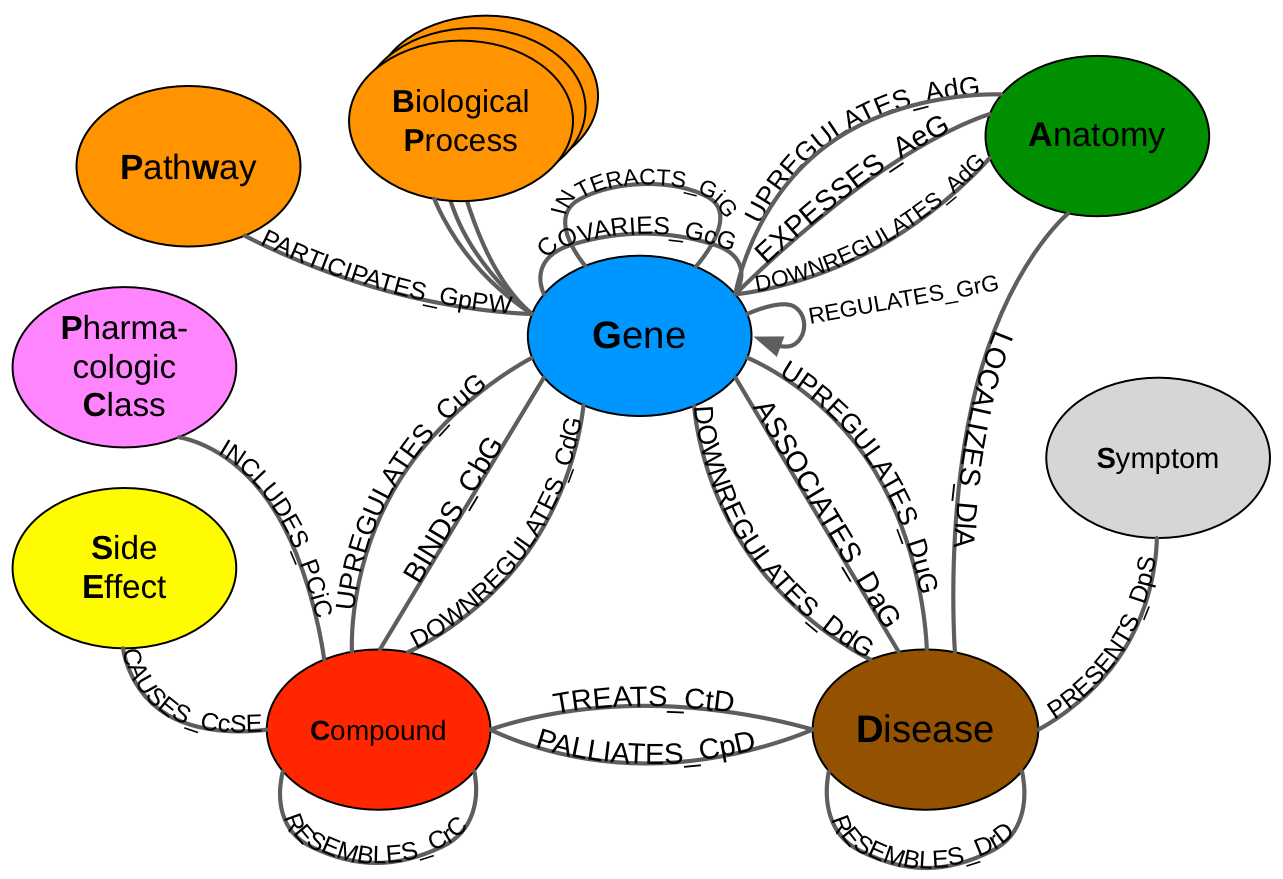

In [36]:
kgrag = KGAG('bolt://neo4j.het.io', "public", "public", model="gpt-4.1-mini")

In [37]:
kgrag.load_query_templates(templates)

In [ ]:
kgrag.qa("Which genes have been associated with breast cancer ?", kg_description=hetionet_kg_description)

In [ ]:
kgrag.qa("Find all genes associated with both liver and kidney cancer ?", kg_description=hetionet_kg_description)

In [ ]:
kgrag.qa("Find all genes that participate in the mitotic spindle checkpoint and are expressed in the lung", kg_description=hetionet_kg_description)

In [ ]:
kgrag.qa("What is the drug with the most side effects for breast cancer ?", kg_description=hetionet_kg_description)

Try it yourselft !

More thoughts:

- Is the output format a Graph query good for an LLM ? Can we verbalised it ?
- Strong reliance on the schema -> there is no learning of the schema.

# 5. A bit on KG embeddings for link predictions

If you are interested in learning more on KG-embeddings for link prediction, have a look at the [pykeen](https://github.com/pykeen/pykeen) library !



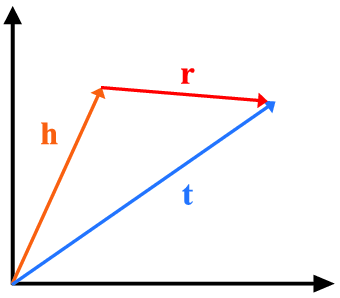

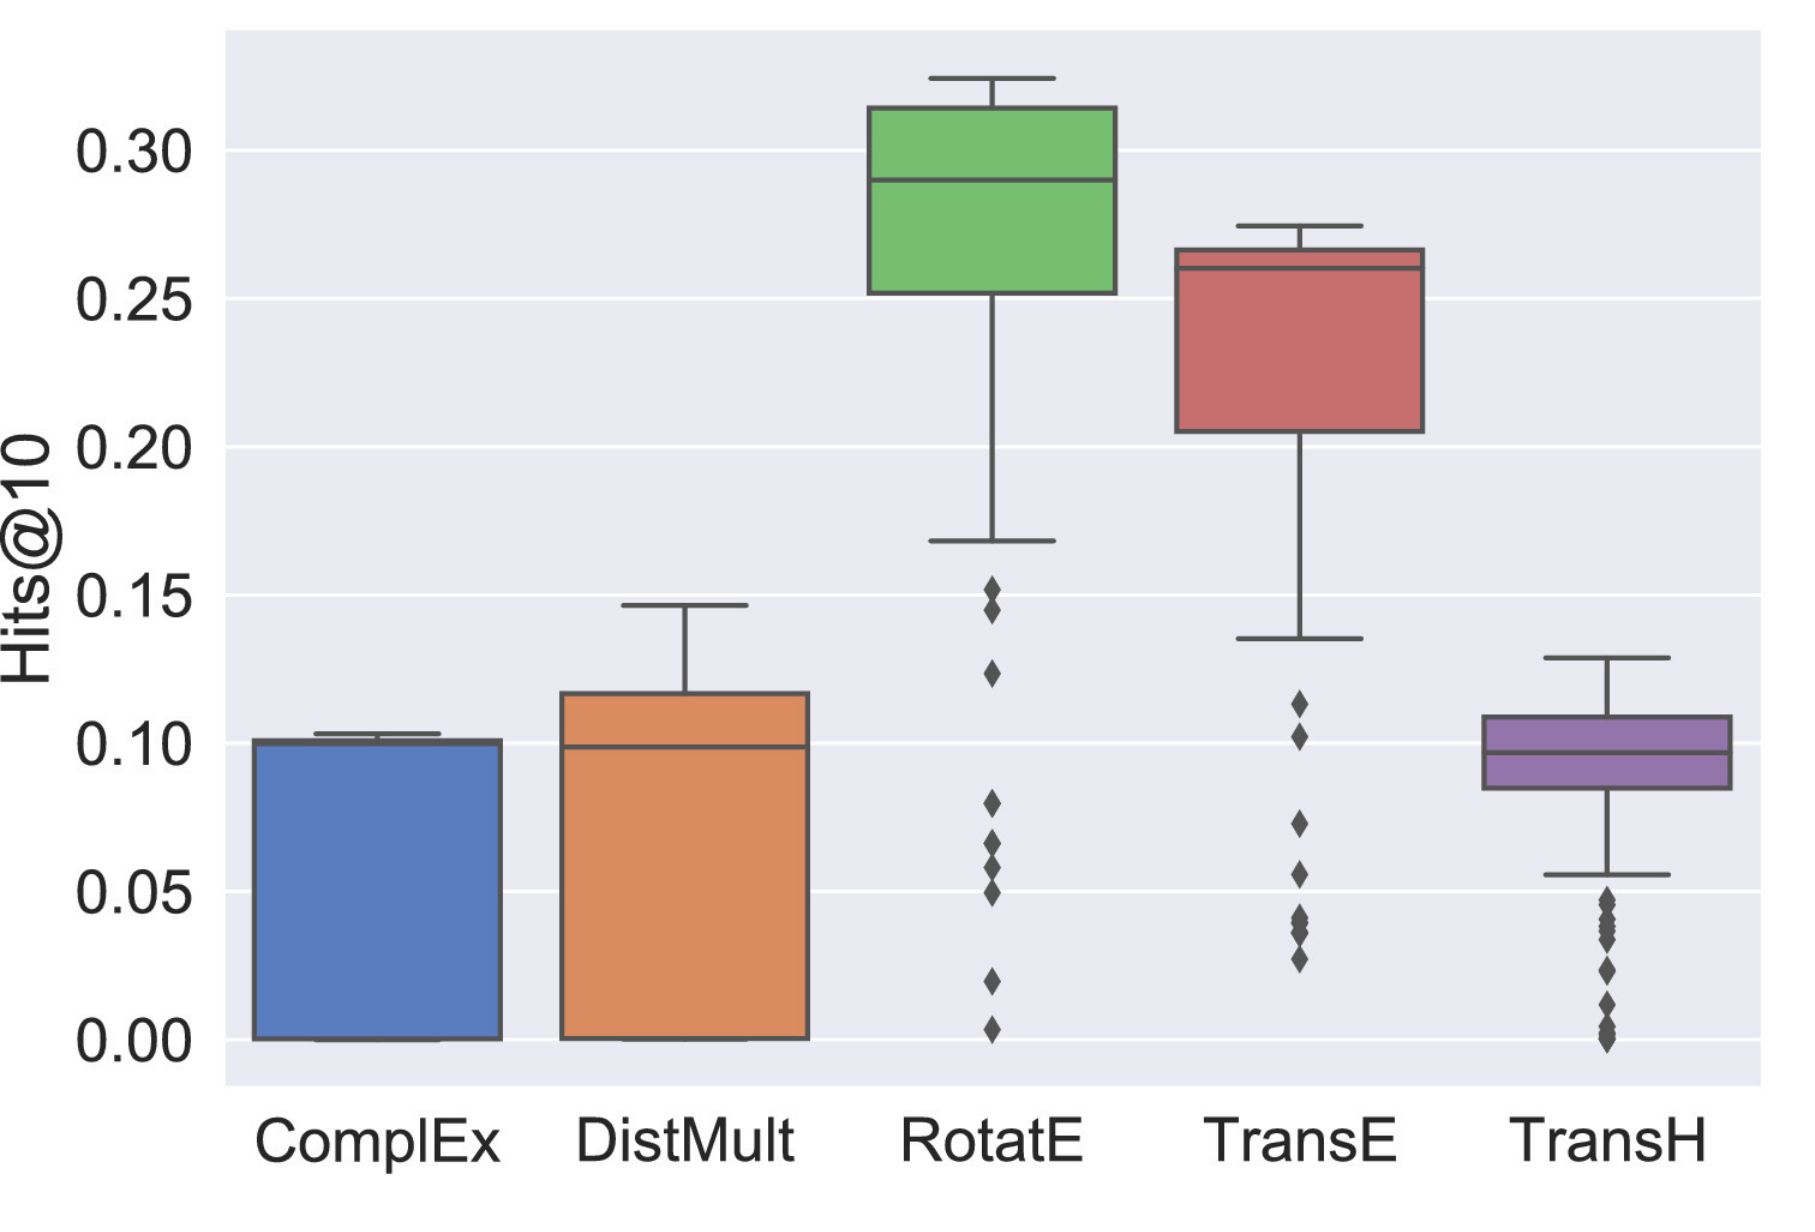


[1] [*Knowledge Graph Embedding Models in Drug Discovery*](https://doi.org/10.1016/j.ailsci.2022.100036)

In [ ]:
! pip install pykeen

Here we just make an example for 10 epochs, **it is not enough given the size of the graph to get a good representation**. You can try it on your own with longer training (~100 epochs)

In [ ]:
# Run this only if you want to train the embeddings
from pykeen.pipeline import pipeline
pipeline_result = pipeline(
    dataset="Hetionet",
    dataset_kwargs={
        "random_state": 42,
        "create_inverse_triples": False,
    },
    model="TransE",
    model_kwargs={
        "embedding_dim": 300,
        "random_seed": 42,
    },
    training_loop="sLCWA",
    training_kwargs={
        "batch_size": 128000,
        "num_epochs": 10
    },
    optimizer="Adagrad",
    optimizer_kwargs={"lr": 0.02},
    negative_sampler_kwargs={
        "num_negs_per_pos": 61,
    },
    random_seed=42,
    evaluator_kwargs={"filtered": True},
    use_testing_data=False,
)

pipeline_result.save_to_directory("/content/outputs/transe-hetionet")

You need to request the tail/head entities with their ids. You can find the map in `outputs/transe-hetionet/training_triples/entity_to_id.tsv.gz`.


Let's try with a simple example: psoriasis (Disease::DOID:8893). Our link prediction task will be about the potential new heads, given the property treat (*CtD* in hetionet).




In [ ]:
from pykeen.datasets import get_dataset
from pykeen.predict import predict_target
dataset = get_dataset(dataset="hetionet")

In [43]:
import torch
model = torch.load("/content/trained_model.pkl",weights_only=False)

In [44]:
pred = predict_target(
    model=model,
    tail="Disease::DOID:8893",
    relation="CtD",
    triples_factory=dataset.training,
)

In [ ]:
pred_filtered = pred.filter_triples(dataset.training)
print(pred_filtered.df)

In this experiment we can see that the top hit will be Compound:DB00675 (Tamoxifen) which is originally used for breast cancer.
*"Tamoxifen is a selective estrogen receptor modulator used to treat estrogen receptor positive breast cancer, reduce the risk of invasive breast cancer following surgery, or reduce the risk of breast cancer in high risk women."*

[1] [*Psoriasis and tamoxifen therapy: a case report*](https://pubmed.ncbi.nlm.nih.gov/8693608/)

cool no ? 😎

let's look at what are the connections in the graph:

Go to [Hetionet Neo4J browser](https://neo4j.het.io/browser/) and use this query:

```cypher
MATCH (c:Compound {name: "Tamoxifen"}),(d:Disease {name:"psoriasis"})
WITH c,d
MATCH p=AllShortestPaths((c)-[r*1..4]-(d))
RETURN p LIMIT 25
```

basically we are trying to see all the shortest path (up to 4) between the 2 entities, to discover what are the connectings entities and relations.

# Additional reference for further reading

[*Graph Reasoning for Question Answering with Triplet Retrieval*](https://arxiv.org/pdf/2305.18742)

[*MindMap: Knowledge Graph Prompting Sparks Graph of Thoughts in
Large Language Models*](https://doi.org/10.18653/v1/2024.acl-long.558)

[*Boosting Language Models Reasoning with Chain-of-Knowledge
Prompting*](https://doi.org/10.18653/v1/2024.acl-long.271)

[*Barack’s Wife Hillary:
Using Knowledge Graphs for Fact-Aware Language Modeling*](https://doi.org/10.18653/v1/P19-1598)

[*Reasoning on Graphs: Faithful and Interpretable Large Language Model Reasoning*](https://arxiv.org/pdf/2310.01061)

[*Biomedical knowledge graph-optimized prompt generation for large language models*](https://doi.org/10.1093/bioinformatics/btae560)